TODO
* Image normalization and scaling
* selected layers trainable=true
* try with berkeley people data
* try with filter/nofilter on same image data
* data augmentation (rotate/mirror original image and filtered image)
* inception v1 


In [100]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline
import pprint as pp

import os
import glob
import numpy as np
import tensorflow as tf

import keras
from keras.layers import (Flatten,Dropout)
from keras.preprocessing import image
from keras.applications.vgg19 import (
    VGG19, preprocess_input, decode_predictions)

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13307455544002521170
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11286285517
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16220969481776354199
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [5]:
# pp.pprint(model.layers)
# pp.pprint(model.output)

In [6]:
# Keras
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Dense, GlobalAveragePooling2D
from keras.datasets import mnist

In [47]:
# load image data

filtered_images_path= glob.glob('./imgs_with_filter/imgs_with_filter/*')
unfiltered_imgs_path=glob.glob('./unfiltered_1083/*')

In [25]:
# load image data

filtered_images_path= glob.glob('/mnt/efs/filters_to_images/filtered_images/*')[:5000]
unfiltered_imgs_path=glob.glob('/mnt/efs/filters_to_images/unfiltered_images/*')[:5000]

In [89]:
import time

images_path=filtered_images_path+unfiltered_imgs_path
images_list=[]
#Inception
image_size = (229,229)

#VGG19
# image_size = (224,224)

old_time = time.time()
for idx, img_path in enumerate(images_path):
    if idx % 100 == 0: print('-----------------{}---------------   time: '.format(idx), time.time() - old_time)
    image_stored=image.load_img(img_path,target_size=image_size)
    
    # Preprocess image for model prediction
# This step handles scaling and normalization for Xception
    x = image.img_to_array(image_stored)
#     x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    images_list.append(x)
    
# X=images_list[0]

-----------------0---------------   time:  0.00010728836059570312
-----------------100---------------   time:  1.359464406967163
-----------------200---------------   time:  2.6855318546295166
-----------------300---------------   time:  4.0711400508880615
-----------------400---------------   time:  5.432503700256348
-----------------500---------------   time:  6.765442609786987
-----------------600---------------   time:  8.12806248664856
-----------------700---------------   time:  9.777694463729858
-----------------800---------------   time:  11.165361881256104
-----------------900---------------   time:  12.711575746536255
-----------------1000---------------   time:  14.066686391830444
-----------------1100---------------   time:  15.557370901107788
-----------------1200---------------   time:  16.972898483276367
-----------------1300---------------   time:  18.374518871307373
-----------------1400---------------   time:  19.76650381088257
-----------------1500---------------   t

In [16]:
X=np.array(images_list)

In [17]:
len(X)


10000

In [27]:
filtered_labels=np.full((len(filtered_images_path),2),(True,False),np.bool)
unfiltered_labels=np.full((len(unfiltered_imgs_path),2),(False,True),np.bool)
y=np.concatenate([filtered_labels,unfiltered_labels])
type(y)

numpy.ndarray

In [30]:
test_split=0.2

In [31]:
#splitting data into test and train
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_split, shuffle=True)


In [ ]:
# from numpy import random
# def generator(features, labels, batch_size):
#  # Create empty arrays to contain batch of features and labels#
#  batch_features = np.zeros((batch_size, 224,224, 3))
#  batch_labels = np.zeros((batch_size,2))
#  while True:
#    for i in range(batch_size):
#      # choose random index in features
#      index= random.choice(len(features),1)
#      batch_features[i] = (features[index])
#      batch_labels[i] = labels[index]
#    yield batch_features, batch_labels

# VGG19 Model 

In [83]:
# Load the VGG19 model
# https://keras.io/applications/#VGG19
VGGmodel = VGG19(
    include_top=False, 
    weights='imagenet')
# model_original = VGG19(
#     include_top=True, 
#     weights='imagenet')

for layer in VGGmodel.layers:
    layer.trainable = True

# add a global spatial average pooling layer
x = VGGmodel.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


# num_classes=2
# my_new_model = Sequential()
# my_new_model.add(VGGmodel)
# my_new_model.add(Flatten())
# my_new_model.add(Dense(num_classes, activation='softmax'))

# # Say not to train first layer (ResNet) model. It is already trained
# my_new_model.layers[0].trainable = False

# this is the model we will train
model = Model(inputs=VGGmodel.input, outputs=predictions)

# pp.pprint(my_new_model.layers)
# pp.pprint(my_new_model.output)

sgd=keras.optimizers.sgd(lr=0.1, decay=0.01)

# #compile the model
# for layer in model.layers:
#     layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

# Inception V3 Model

In [108]:
from keras.applications.inception_v3 import (
    InceptionV3, preprocess_input, decode_predictions)
# Load the VGG19 model
# https://keras.io/applications/#VGG19
Inceptionmodel = InceptionV3(
    include_top=False, 
    weights='imagenet')
# model_original = VGG19(
#     include_top=True, 
#     weights='imagenet')

for layer in Inceptionmodel.layers:
    layer.trainable = True
print(Inceptionmodel.output)

#Adding custom Layers 
x = Inceptionmodel.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)


# num_classes=2
# my_new_model = Sequential()
# my_new_model.add(VGGmodel)
# my_new_model.add(Flatten())
# my_new_model.add(Dense(num_classes, activation='softmax'))

# # Say not to train first layer (ResNet) model. It is already trained
# my_new_model.layers[0].trainable = False

# this is the model we will train
model = Model(inputs=Inceptionmodel.input, outputs=predictions)

# pp.pprint(my_new_model.layers)
# pp.pprint(my_new_model.output)

sgd=keras.optimizers.sgd(lr=0.1, decay=0.01)

# #compile the model
# for layer in model.layers:
#     layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

Tensor("mixed10_6/concat:0", shape=(?, ?, ?, 2048), dtype=float32)


In [109]:
# model.save_weights('model.h5')

# train the model on the new data for a few epochs
# model.fit_generator("")
model.fit(X_train,y_train,batch_size=10,epochs=1,shuffle=True)

In [110]:
# from tensorflow.python.keras.applications.vgg import preprocess_input
trainDatagen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input)

testDatagen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input)


trainDatagen.fit(X_train)
testDatagen.fit(X_test)

In [111]:
epochs=5
batch_size=100

steps_per_epoch=len(X_train)/batch_size
validation_steps=len(X_test)/batch_size

#Train the model
my_new_model.fit_generator(generator(X_train, y_train, batch_size), steps_per_epoch=steps_per_epoch, epochs=epochs , validation_data=generator(X_test,y_test,batch_size), validation_steps=validation_steps)

In [ ]:
#Train the model
history= model.fit_generator(trainDatagen.flow(X_train, y_train, batch_size, shuffle=True), steps_per_epoch=steps_per_epoch, epochs=epochs , validation_data=testDatagen.flow(X_test,y_test,batch_size, shuffle=True), validation_steps=validation_steps)

Epoch 1/5
80/80 [==============================] - 185s 2s/step - loss: 0.5054 - acc: 0.4922 - val_loss: 0.4690 - val_acc: 0.5310
Epoch 2/5
80/80 [==============================] - 156s 2s/step - loss: 0.5077 - acc: 0.4922 - val_loss: 0.4690 - val_acc: 0.5310
Epoch 3/5
80/80 [==============================] - 156s 2s/step - loss: 0.5077 - acc: 0.4922 - val_loss: 0.4690 - val_acc: 0.5310
Epoch 4/5
66/80 [=======================>......] - ETA: 25s - loss: 0.5098 - acc: 0.4902

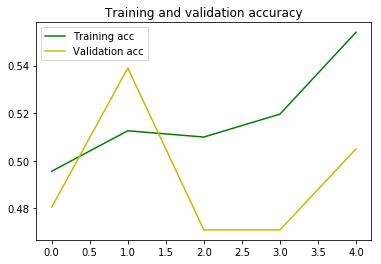

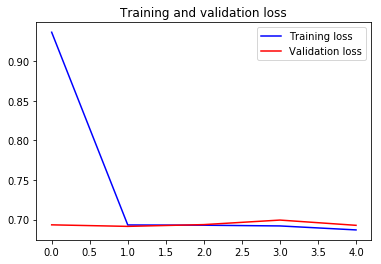

In [75]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# plt.show()

In [ ]:
# model.load_weights('model.h5')

In [42]:
def predict(img_path):
    image_stored=image.load_img(img_path,target_size=image_size)
    
    # Preprocess image for model prediction
# This step handles scaling and normalization for Xception
    x = image.img_to_array(image_stored)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    prediction = model.predict(x)
    print(type(prediction))
    print(prediction)
#     decode_predictions(prediction, top=2)


predict('/mnt/efs/filters_to_images/filtered_images/ILSVRC2012_val_00000111.JPEG')


<class 'numpy.ndarray'>
[[5.3103686e-05 9.9994695e-01]]


In [43]:
predict('/mnt/efs/filters_to_images/unfiltered_images/ILSVRC2012_val_00000111.JPEG')


<class 'numpy.ndarray'>
[[3.0422874e-04 9.9969578e-01]]


In [45]:
predict('./testimages/filtered/img1.jpg')

OSError: cannot identify image file './testimages/filtered/img1.jpg'

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)